
[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Démarrage de la génération des masques guides ---
Nombre d'images trouvées : 144
Traitement : 20/144 images...
Traitement : 40/144 images...
Traitement : 60/144 images...
Traitement : 100/144 images...
Traitement : 120/144 images...
Traitement : 140/144 images...
Terminé. 135 images utilisées.
Fichier numpy sauvegardé dans : ./Results/GuideMasks/


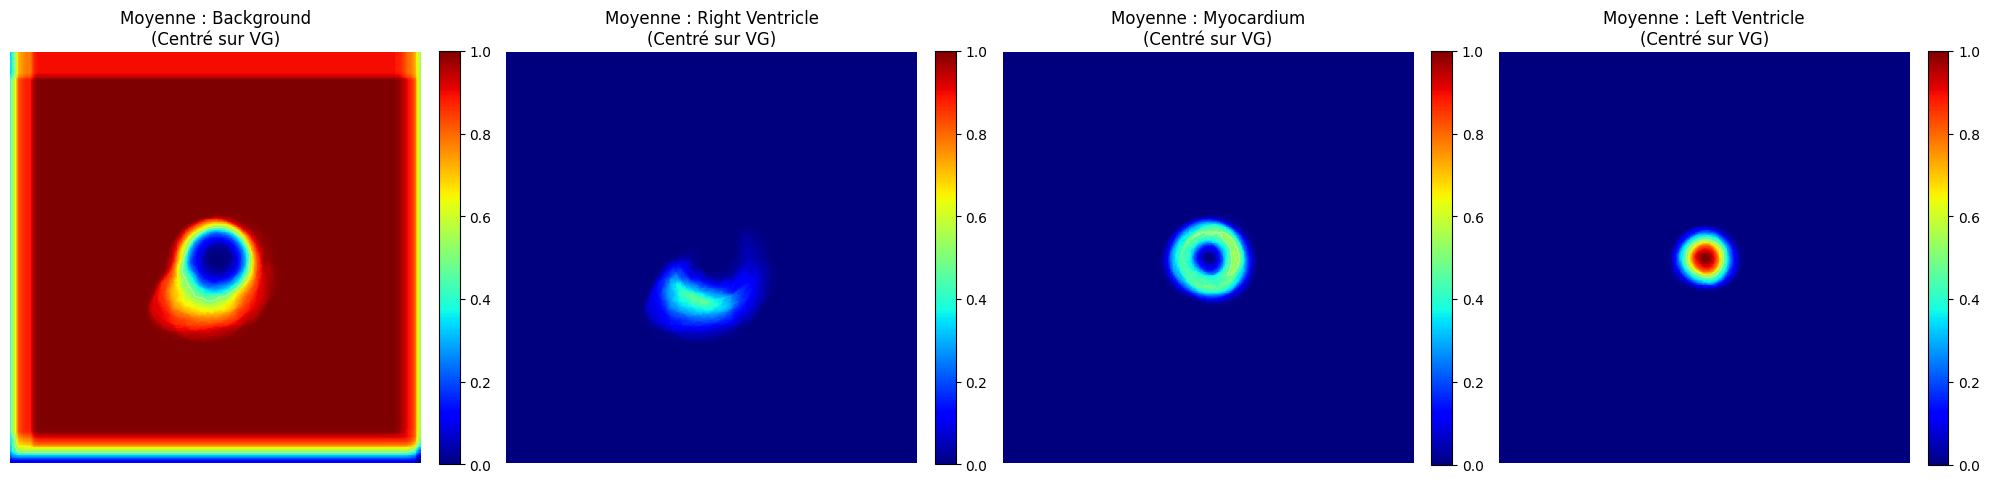

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from scipy.ndimage import center_of_mass, shift
import os

!pip install importnb

from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
from UNet_Base_steroid import *
from UNet_2_0 import *
from UNet_2_0_steroid import *
from UNet_3_0 import *
import random
import torch
import pdb

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_mac import getTargetSegmentation, dice_score

import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt as edt
from scipy import ndimage as ndi

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from importnb import Notebook
with Notebook():
    from Mask_Guide import *

import torch.nn as nn
import os
import time
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")


# Imports de vos modules existants
import medicalDataLoader
from utils import getTargetSegmentation

# --- Paramètres ---
ROOT_DIR = './Data/'
NUM_CLASSES = 4
IMG_SIZE = 256  # Taille supposée des images (256x256)
LV_CLASS_INDEX = 3  # L'indice de classe du Ventricule Gauche (Endocarde)
SAVE_DIR = './Results/GuideMasks/'

def generate_guide_masks():
    print("--- Démarrage de la génération des masques guides ---")
    
    # 1. Configuration du Loader (Sans augmentation aléatoire !)
    # On veut les données brutes pour calculer des statistiques fiables
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set = medicalDataLoader.MedicalImageDataset(
        'train', 
        ROOT_DIR, 
        transform=transform, 
        mask_transform=mask_transform, 
        augment=False,      # IMPORTANT : Pas d'augmentation (rotation/scale)
        equalize=False
    )
    
    loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

    # 2. Initialisation des accumulateurs [4, H, W]
    # On va sommer les masques binaires centrés ici
    accumulated_masks = np.zeros((NUM_CLASSES, IMG_SIZE, IMG_SIZE), dtype=np.float32)
    count_valid_images = 0

    print(f"Nombre d'images trouvées : {len(loader)}")

    # 3. Boucle sur le dataset
    for i, data in enumerate(loader):
        # Les images ne nous intéressent pas ici, seulement les labels
        _, labels, _ = data
        
        # Conversion du label (0-1) en classes entières (0, 1, 2, 3)
        # labels shape : [1, 1, 256, 256] -> [256, 256]
        gt_mask = getTargetSegmentation(labels).numpy()
        
        # --- Étape A : Trouver le centre du Ventricule Gauche (Classe 3) ---
        lv_mask = (gt_mask == LV_CLASS_INDEX).astype(int)
        
        # Si pas de VG dans cette coupe (ex: coupe très basale ou apicale), on ignore ou on centre par défaut
        if lv_mask.sum() == 0:
            continue
            
        # Calcul du barycentre (y, x) du masque binaire du VG
        center_y, center_x = center_of_mass(lv_mask)
        
        # --- Étape B : Calculer le vecteur de décalage (shift) ---
        # On veut amener (center_y, center_x) vers (128, 128)
        target_center = IMG_SIZE // 2
        shift_y = target_center - center_y
        shift_x = target_center - center_x
        
        # --- Étape C : Décaler et accumuler chaque classe ---
        for c in range(NUM_CLASSES):
            # Créer le masque binaire pour la classe c
            class_mask = (gt_mask == c).astype(np.float32)
            
            # Appliquer la translation
            # order=0 (nearest) pour garder des valeurs binaires nettes lors du shift
            # cval=0.0 remplit les bords créés par le décalage avec 0 (background)
            shifted_mask = shift(class_mask, shift=[shift_y, shift_x], order=0, cval=0.0)
            
            accumulated_masks[c] += shifted_mask

        count_valid_images += 1
        
        if (i+1) % 20 == 0:
            print(f"Traitement : {i+1}/{len(loader)} images...")

    # 4. Normalisation (Moyenne)
    # Le résultat est une map de probabilité entre 0 et 1 pour chaque pixel
    if count_valid_images > 0:
        guide_masks = accumulated_masks / count_valid_images
    else:
        print("Erreur : Aucune image valide avec un VG trouvée.")
        return

    print(f"Terminé. {count_valid_images} images utilisées.")

    # 5. Sauvegarde et Visualisation
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    # Sauvegarder en fichier numpy pour réutilisation future (ex: dans la loss ou en input du réseau)
    np.save(os.path.join(SAVE_DIR, 'guide_masks_centered_LV.npy'), guide_masks)
    print(f"Fichier numpy sauvegardé dans : {SAVE_DIR}")

    # Affichage
    visualize_guides(guide_masks)

def visualize_guides(guide_masks):
    class_names = ["Background", "Right Ventricle", "Myocardium", "Left Ventricle"]
    
    plt.figure(figsize=(20, 5))
    
    for c in range(NUM_CLASSES):
        plt.subplot(1, 4, c+1)
        # On affiche la heatmap (probabilité de présence)
        plt.imshow(guide_masks[c], cmap='jet', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"Moyenne : {class_names[c]}\n(Centré sur VG)")
        plt.axis('off')
        
        # Ajout d'un contour pour voir la forme moyenne (ex: isocontour 0.5)
        plt.contour(guide_masks[c], levels=[0.5], colors='white', linewidths=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'visualisation_guides.png'))
    plt.show()

if __name__ == "__main__":
    generate_guide_masks()

--- Application du flou Gaussien (Sigma=5) ---
Guides chargés. Shape : (4, 256, 256)
Guides floutés sauvegardés sous : ./Results/GuideMasks/guide_masks_probabilistic.npy


<Figure size 1200x600 with 0 Axes>

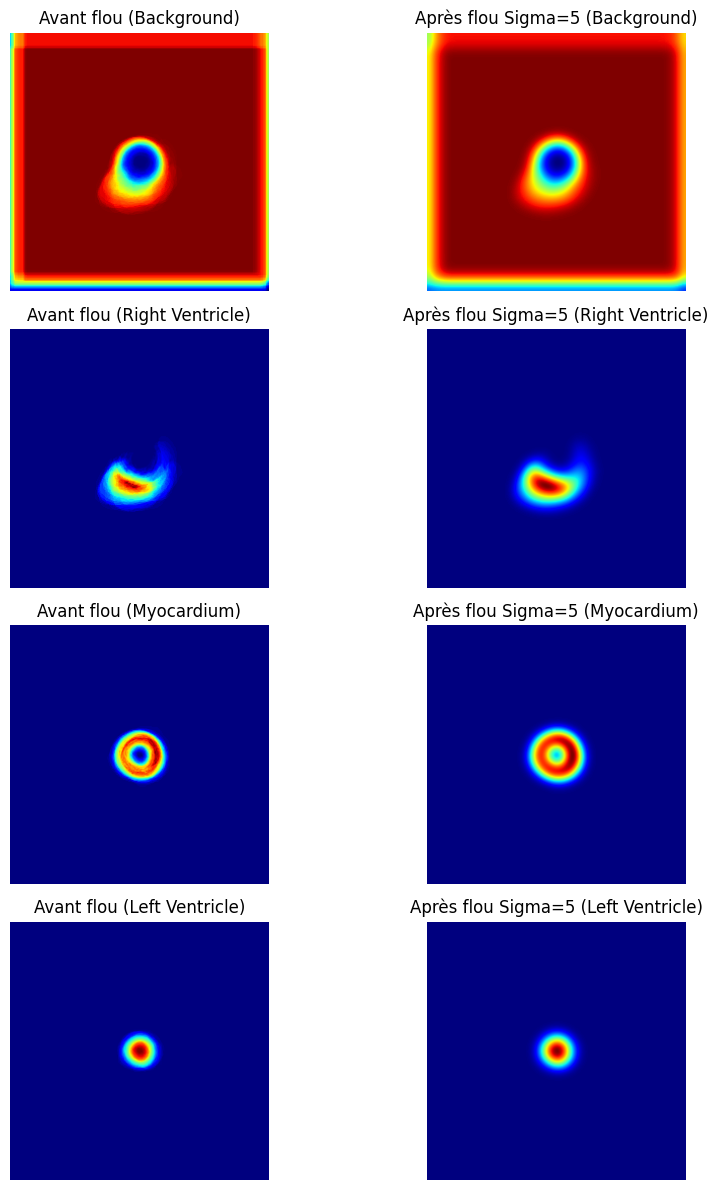

In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# --- PARAMÈTRES ---
LOAD_PATH = './Results/GuideMasks/guide_masks_centered_LV.npy'
SAVE_PATH = './Results/GuideMasks/guide_masks_probabilistic.npy'
SIGMA = 5  # Intensité du flou (plus c'est haut, plus la tolérance spatiale est grande)
NUM_CLASSES = 4

def apply_gaussian_blur_to_guides():
    print(f"--- Application du flou Gaussien (Sigma={SIGMA}) ---")
    
    if not os.path.exists(LOAD_PATH):
        print(f"Erreur : Le fichier {LOAD_PATH} n'existe pas. Lancez la génération précédente d'abord.")
        return

    # 1. Chargement du masque guide net (centré)
    guides = np.load(LOAD_PATH)
    print(f"Guides chargés. Shape : {guides.shape}")

    # 2. Application du flou
    guides_blurred = np.zeros_like(guides)
    
    for c in range(NUM_CLASSES):
        # On floute moins le background (classe 0) ou pas du tout, 
        # mais ici on floute tout pour avoir des gradients lisses partout.
        # On peut réduire le sigma pour le background si on veut garder des bords plus nets.
        current_sigma = SIGMA if c > 0 else SIGMA
        
        guides_blurred[c] = gaussian_filter(guides[c], sigma=current_sigma)
        
        # Normalisation : On remet le max à 1 pour aider le réseau
        # (Sauf si le masque est vide, ce qui ne devrait pas arriver ici)
        max_val = guides_blurred[c].max()
        if max_val > 0:
            guides_blurred[c] /= max_val

    # Optionnel : Recalculer le background proprement comme le complémentaire
    # (Souvent mieux pour que la somme des probas soit ~1, mais pas strict pour un input de réseau)
    # guides_blurred[0] = 1 - np.sum(guides_blurred[1:], axis=0)
    # guides_blurred[0] = np.clip(guides_blurred[0], 0, 1)

    # 3. Sauvegarde
    np.save(SAVE_PATH, guides_blurred.astype(np.float32))
    print(f"Guides floutés sauvegardés sous : {SAVE_PATH}")

    # 4. Visualisation comparative
    class_names = ["Background", "Right Ventricle", "Myocardium", "Left Ventricle"]
    plt.figure(figsize=(12, 6))
    
    # On affiche seulement le VG (Classe 3) pour comparer avant/après
    c = 3 
    
    plt.figure(figsize=(10, 12))

    for c in range(4):
        # Avant flou
        plt.subplot(4, 2, 2*c + 1)
        plt.imshow(guides[c], cmap="jet")
        plt.title(f"Avant flou ({class_names[c]})")
        plt.axis("off")
        
        # Après flou
        plt.subplot(4, 2, 2*c + 2)
        plt.imshow(guides_blurred[c], cmap="jet")
        plt.title(f"Après flou Sigma={SIGMA} ({class_names[c]})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    apply_gaussian_blur_to_guides()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

class GuideSTN(nn.Module):
    def __init__(self, in_channels=1):
        super(GuideSTN, self).__init__()
        
        # Réseau de localisation (CNN simple)
        # Input: 256x256
        self.loc_net = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=7), # -> 250x250
            nn.MaxPool2d(2, stride=2),                # -> 125x125
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),          # -> 121x121
            nn.MaxPool2d(2, stride=2),                # -> 60x60
            nn.ReLU(True),
            nn.Conv2d(10, 10, kernel_size=3),         # -> 58x58
            nn.MaxPool2d(2, stride=2),                # -> 29x29
            nn.ReLU(True)
        )
        
        # Régresseur pour la matrice affine 2x3 (6 paramètres)
        # La taille d'entrée dépend de la sortie du CNN (ici 10 canaux * 29 * 29)
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 29 * 29, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2) # Sortie : 6 valeurs pour la matrice 2x3
        )

        # --- INITIALISATION CRITIQUE ---
        # On initialise la dernière couche pour qu'elle sorte l'identité
        # [1, 0, 0]
        # [0, 1, 0]
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(xs.size(0), -1) # Aplatir
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3) # Reshape en [Batch, 2, 3]
        return theta

def apply_stn_transform(guide_tensor, theta, output_size):
    """
    Applique la transformation affine prédite (theta) au masque guide.
    """
    B = theta.shape[0]
    
    # Si le guide est unique, on le répète pour le batch
    if guide_tensor.dim() == 3: # [C, H, W]
        guides = guide_tensor.unsqueeze(0).expand(B, -1, -1, -1)
    else:
        guides = guide_tensor # Déjà [B, C, H, W]
        
    # 1. Générer la grille d'échantillonnage
    # theta correspond à la transformation inverse (Target -> Source) pour grid_sample
    grid = F.affine_grid(theta, (B, guides.shape[1], *output_size), align_corners=False)
    
    # 2. Appliquer la transformation (Sampling)
    # mode='bilinear' est important pour que le gradient passe bien (backprop)
    # padding_mode='zeros' remplit les bords créés avec du noir
    transformed_guides = F.grid_sample(guides, grid, mode='bilinear', padding_mode='zeros', align_corners=False)
    
    return transformed_guides

def visualize_stn_step(image, transformed_guide, pred, epoch, batch_idx, save_dir=None):
    """
    Affiche un triplet : Image, Guide Transformé par STN, Prédiction Finale.
    Permet de voir si le STN a bien appris à zoomer/centrer sur le cœur.
    """
    # Conversion Numpy (premier élément du batch)
    img = image[0, 0].detach().cpu().numpy()
    guide = transformed_guide[0, 3].detach().cpu().numpy() # Canal VG
    pred_mask = torch.argmax(pred[0], dim=0).detach().cpu().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Image + Guide (Overlay)
    axs[0].imshow(img, cmap='gray')
    axs[0].imshow(guide, cmap='jet', alpha=0.5, vmin=0, vmax=1)
    axs[0].set_title(f"STN Aligned Guide (Epoch {epoch})")
    axs[0].axis('off')
    
    # 2. Guide seul (pour voir la déformation)
    axs[1].imshow(guide, cmap='jet')
    axs[1].set_title("Masque déformé par STN")
    axs[1].axis('off')
    
    # 3. Prédiction Finale
    axs[2].imshow(pred_mask, cmap='jet')
    axs[2].set_title("Prédiction U-Net")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [30]:
def shift_batch_on_gpu(guide_tensor, offsets_norm, H, W):
    """
    guide_tensor : [4, H, W] (Le masque guide de base sur GPU)
    offsets_norm : [Batch, 2] (Les prédictions y, x normalisées entre -1 et 1)
    Retourne : [Batch, 4, H, W] (Les guides alignés pour chaque image)
    """
    B = offsets_norm.shape[0]
    C = guide_tensor.shape[0]
    
    # On prépare le tenseur de sortie
    # .expand crée une vue du guide répété B fois [B, 4, H, W]
    guides_batch = guide_tensor.unsqueeze(0).expand(B, -1, -1, -1).clone()
    
    # Convertir les offsets normalisés en pixels (décalage par rapport au centre 0)
    # offset 0 = centre. offset 1 = bord.
    # Le guide est centré en (0,0) relative, on veut le bouger de (dy, dx)
    
    # Note: Le locator prédit la position absolue. 
    # Le guide est centré à (H//2, W//2). 
    # Le shift à appliquer est : pred_pos - centre_image
    
    shift_y = (offsets_norm[:, 0] * (H / 2)).long()
    shift_x = (offsets_norm[:, 1] * (W / 2)).long()
    
    for b in range(B):
        dy = shift_y[b].item()
        dx = shift_x[b].item()
        
        # torch.roll déplace les pixels de manière circulaire
        # C'est très rapide. Les pixels qui sortent d'un côté rentrent de l'autre.
        # Comme on a du padding (background) autour du masque, c'est acceptable.
        guides_batch[b] = torch.roll(guides_batch[b], shifts=(dy, dx), dims=(1, 2))
        
        # Optionnel : Masquer ce qui a "rollé" de l'autre côté (si le décalage est énorme)
        # Pour ce projet, on peut ignorer ça pour l'instant.

    return guides_batch